In [121]:
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.nn as nn
import numpy as np
import random
import matplotlib.pyplot as plt
from IPython.display import clear_output

In [2]:
def prepare_sequence(seq, to_ix):
    idxs = [to_ix[w] for w in seq]
    tensor = torch.LongTensor(idxs)
    return autograd.Variable(tensor)


def create_dict(training_data):
    word_to_ix = {}
    for sent in training_data:
        for word in sent:
            if word not in word_to_ix:
                word_to_ix[word] = len(word_to_ix)
    ix_to_word = dict([(y, x) for (y, x) in enumerate(word_to_ix)])
    return word_to_ix, ix_to_word


def create_data(sentences):
    training_data = []
    for s in sentences:
        for i in range(len(s)):
            training_data.append(s)
            s = np.roll(s,-1).tolist()
    return training_data

In [6]:
class LSTMTagger(nn.Module):

    def __init__(self, embedding_dim, hidden_dim, vocab_size):
        super(LSTMTagger, self).__init__()
        self.hidden_dim = hidden_dim

        self.word_embeddings = nn.Embedding(vocab_size, embedding_dim)

        # The LSTM takes word embeddings as inputs, and outputs hidden states
        # with dimensionality hidden_dim.
        self.lstm = nn.LSTM(embedding_dim, hidden_dim)

        # The linear layer that maps from hidden state space to tag space
        self.hidden2voc = nn.Linear(hidden_dim, vocab_size)
        self.hidden = self.init_hidden()

    def init_hidden(self):
        # Before we've done anything, we dont have any hidden state.
        # Refer to the Pytorch documentation to see exactly
        # why they have this dimensionality.
        # The axes semantics are (num_layers, minibatch_size, hidden_dim)
        return (autograd.Variable(torch.zeros(1, 1, self.hidden_dim)),
                autograd.Variable(torch.zeros(1, 1, self.hidden_dim)))

    def forward(self, sentence):
        embeds = self.word_embeddings(sentence)
        lstm_out, self.hidden = self.lstm(embeds.view(len(sentence), 1, -1), self.hidden)
        voc_space = self.hidden2voc(lstm_out.view(len(sentence), -1))
        voc_scores = F.log_softmax(voc_space, dim=1)
        return voc_scores

In [107]:
sentences = ["The dog ate the apple . \n".split(' '), 
             "One cat drank milk . \n".split(' '),
             "A bird flew up high . \n".split(' '),
             "The rat ate the bread . \n".split(' '), 
             "Two cows drank milk . \n".split(' '),
             "A turtle swam up high . \n".split(' '),
             "The lion ate a person . \n".split(' '), 
             "One bat drank blood . \n".split(' '),
             "A tiger jumped up high . \n".split(' '),
             "The mouse ate the cheese . \n".split(' '), 
             "Two sheep drank water . \n".split(' '),
             "A horse jumped up high . \n".split(' '),
             "The car drove fast . \n".split(' '),
             "One dog drank the milk . \n".split(' '),
             "Two fish swam in water . \n".split(' '),
             "The bat ate the apple . \n".split(' '),
             "The bird flew fast . \n".split(' '),
             "A lion ate the sheep . \n".split(' '),]

sentences = ["THE DOG ATE THE APPLE . \n".split(' '), 
             "THE DOG DRANK THE WATER . \n".split(' '),
             "THE CAT ATE AN APPLE . \n".split(' '),
             "THE CAT DRANK THE MILK . \n".split(' '),
             
             "THE LION RAN FAST . \n".split(' '),
             "THE LION ATE THE DOG . \n".split(' '),
             "THE LION DRANK . \n".split(' '),
             "THE DOG RAN . \n".split(' ')]

training_data = create_data(sentences)
word_to_ix, ix_to_word = create_dict(training_data)
print(word_to_ix)

EMBEDDING_DIM = 2*len(word_to_ix)
HIDDEN_DIM = EMBEDDING_DIM*2


{'THE': 0, 'DOG': 1, 'ATE': 2, 'APPLE': 3, '.': 4, '\n': 5, 'DRANK': 6, 'WATER': 7, 'CAT': 8, 'AN': 9, 'MILK': 10, 'LION': 11, 'RAN': 12, 'FAST': 13}


In [ ]:
model = LSTMTagger(EMBEDDING_DIM, HIDDEN_DIM, len(word_to_ix))
loss_function = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1)

EPOCHS = 200
loss_save = []
for epoch in range(EPOCHS):
    if epoch % 5 == 0:
        clear_output(wait=True)
        print("Epoch... ", epoch, "out of", EPOCHS)
#     training_data = random.sample(training_data, len(training_data))
    for sentence in sentences:
        tags = np.roll(sentence,-1).tolist()

        # Step 1. Remember that Pytorch accumulates gradients.
        # We need to clear them out before each instance
        model.zero_grad()

        # Also, we need to clear out the hidden state of the LSTM,
        # detaching it from its history on the last instance.
        model.hidden = model.init_hidden()

        sentence_in = prepare_sequence(sentence, word_to_ix)
        targets = prepare_sequence(tags, word_to_ix)
  
        tag_scores = model(sentence_in)

        loss = loss_function(tag_scores, targets)
        loss.backward()
        loss_save.append(loss.data)
        optimizer.step()

Epoch...  135 out of 200


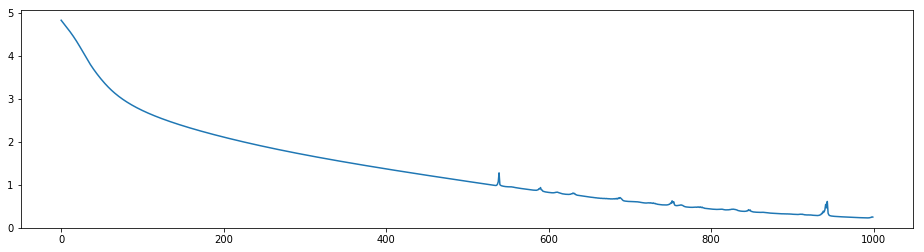

In [112]:
plt.figure(figsize = [16,4])
plt.plot(loss_save, '-', ms=3)
plt.show()

In [119]:
input_word = 'Sam'
print(input_word, end=' ')

model.hidden = model.init_hidden()

for i in range(200):
    inputs = prepare_sequence([input_word], word_to_ix)
    
    tag_scores = model(inputs)
    
    input_word = ix_to_word[int(tag_scores.max(dim=1)[1])]
    print(input_word, end=' ')

Sam 
 I am Sam 
 I am Sam 
  
 That Sam-I-am 
 That Sam-I-am 
  
 I do not like 
 Green eggs and ham. 
  
 Would you like them 
 Here or there? 
  
 I would not like them 
 Here or there. 
 I would not like them 
 Anywhere. 
 I do not like 
 Green eggs and ham. 
  
 I do not like them, 
 Sam-I-am. 
  
 Would you like them 
 In a house? 
 Would you like them 
 With a mouse? 
  
 I do not like them 
 In a house. 
 I do not like them 
 With a mouse. 
 I do not like them 
 Here or there. 
 I do not like them 
 Anywhere. 
 I do not like green eggs and ham. 
 I do not like them, Sam-I-am. 
  
 Would you eat them 
 In a box? 
 Would you eat them 
 With a fox? 
  
 Not in a box. 
 Not with a fox. 
 Not in a house. 
 Not with a mouse. 
 I would 

In [110]:
sentences = ['I am Daniel \n I am Sam \n Sam I am \n  \n That Sam-I-am \n That Sam-I-am! \n I do not like \n That Sam-I-am \n  \n Do you like \n Green eggs and ham \n  \n I do not like them, \n Sam-I-am. \n I do not like \n Green eggs and ham. \n  \n Would you like them \n Here or there? \n  \n I would not like them \n Here or there. \n I would not like them \n Anywhere. \n I do not like \n Green eggs and ham. \n I do not like them, \n Sam-I-am \n  \n Would you like them \n In a house? \n Would you like them \n With a mouse? \n  \n I do not like them \n In a house. \n I do not like them \n With a mouse. \n I do not like them \n Here or there. \n I do not like them \n Anywhere. \n I do not like green eggs and ham. \n I do not like them, Sam-I-am. \n  \n Would you eat them \n In a box? \n Would you eat them \n With a fox? \n  \n Not in a box. \n Not with a fox. \n Not in a house. \n Not with a mouse. \n I would not eat them here or there. \n I would not eat them anywhere. \n I would not eat green eggs and ham. \n I do not like them, Sam-I-am. \n  \n Would you? Could you? \n In a car? \n Eat them! Eat them! \n Here they are. \n  \n I woould not, \n Could not, \n In a car \n  \n You may like them. \n You will see. \n You may like them \n In a tree? \n  \n I would not, could not in a tree. \n Not in a car! You let me be. \n I do not like them in a box. \n I do not like them with a fox \n I do not like them in a house \n I do mot like them with a mouse \n I do not like them here or there. \n I do not like them anywhere. \n I do not like green eggs and ham. \n I do not like them, Sam-I-am. \n  \n A train! A train! \n A train! A train! \n Could you, would you \n On a train? \n  \n Not on a train! Not in a tree! \n Not in a car! Sam! Let me be! \n I would not, could not, in a box. \n I could not, would not, with a fox. \n I will not eat them with a mouse \n I will not eat them in a house. \n I will not eat them here or there. \n I will not eat them anywhere. \n I do not like them, Sam-I-am. \n  \n Say! \n In the dark? \n Here in the dark! \n Would you, could you, in the dark? \n  \n I would not, could not, \n In the dark. \n  \n Would you, could you, \n In the rain? \n  \n I would not, could not, in the rain. \n Not in the dark. Not on a train, \n Not in a car, Not in a tree. \n I do not like them, Sam, you see. \n Not in a house. Not in a box. \n Not with a mouse. Not with a fox. \n I will not eat them here or there. \n I do not like them anywhere! \n  \n You do not like \n Green eggs and ham? \n  \n I do not \n Like them, \n Sam-I-am. \n  \n Could you, would you, \n With a goat? \n  \n I would not, \n Could not. \n With a goat! \n  \n Would you, could you, \n On a boat? \n  \n I could not, would not, on a boat. \n I will not, will not, with a goat. \n I will not eat them in the rain. \n I will not eat them on a train. \n Not in the dark! Not in a tree! \n Not in a car! You let me be! \n I do not like them in a box. \n I do not like them with a fox. \n I will not eat them in a house. \n I do not like them with a mouse. \n I do not like them here or there. \n I do not like them anywhere! \n  \n I do not like \n Green egss \n And ham! \n  \n I do not like them, \n Sam-I-am. \n  \n You do not like them. \n So you say. \n Try them! Try them! \n And you may. \n Try them and you may I say. \n  \n Sam! \n If you will let me be, \n I will try them. \n You will see. \n  \n Say! \n I like green eggs and ham! \n I do! I like them, Sam-I-am! \n And I would eat them in a boat! \n And I would eat them with a goat... \n And I will eat them in the rain. \n And in the dark. And on a train. \n And in a car. And in a tree. \n They are so goodm so goodm you see! \n  \n So I will eat them in a box. \n And I will eat them with a fox. \n And I will eat them in a house. \n And I will eat them with a mouse. \n And I will eat them here and there. \n Say! I will eat them anhywhere! \n  \n I do so like \n Green eggs and ham! \n Thank you! \n Thank you, \n Sam-I-am'.split(' ')]

training_data = create_data(sentences)
word_to_ix, ix_to_word = create_dict(training_data)
print(word_to_ix)

EMBEDDING_DIM = 2*len(word_to_ix)
HIDDEN_DIM = EMBEDDING_DIM*2

{'I': 0, 'am': 1, 'Daniel': 2, '\n': 3, 'Sam': 4, '': 5, 'That': 6, 'Sam-I-am': 7, 'Sam-I-am!': 8, 'do': 9, 'not': 10, 'like': 11, 'Do': 12, 'you': 13, 'Green': 14, 'eggs': 15, 'and': 16, 'ham': 17, 'them,': 18, 'Sam-I-am.': 19, 'ham.': 20, 'Would': 21, 'them': 22, 'Here': 23, 'or': 24, 'there?': 25, 'would': 26, 'there.': 27, 'Anywhere.': 28, 'In': 29, 'a': 30, 'house?': 31, 'With': 32, 'mouse?': 33, 'house.': 34, 'mouse.': 35, 'green': 36, 'eat': 37, 'box?': 38, 'fox?': 39, 'Not': 40, 'in': 41, 'box.': 42, 'with': 43, 'fox.': 44, 'here': 45, 'anywhere.': 46, 'you?': 47, 'Could': 48, 'car?': 49, 'Eat': 50, 'them!': 51, 'they': 52, 'are.': 53, 'woould': 54, 'not,': 55, 'car': 56, 'You': 57, 'may': 58, 'them.': 59, 'will': 60, 'see.': 61, 'tree?': 62, 'could': 63, 'tree.': 64, 'car!': 65, 'let': 66, 'me': 67, 'be.': 68, 'fox': 69, 'house': 70, 'mot': 71, 'mouse': 72, 'A': 73, 'train!': 74, 'you,': 75, 'On': 76, 'train?': 77, 'on': 78, 'tree!': 79, 'Sam!': 80, 'Let': 81, 'be!': 82, 'Say!